# DBSCAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read customer dataframe
df = pd.read_csv('customer_dataframe.csv', sep='\t', index_col=0)
df.head()

,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder
CustomerID,,,,,,,,,,,,,,
17850,1702,21,141,12,48.628571,5317.89,6.36,107.25,151.939714,31,3.960370,34,4.137478,3.186426
13047,1355,105,309,3,84.687500,3089.10,6.64,68.00,193.068750,35,3.926082,9,5.420969,3.875000
12583,4978,114,714,100,292.823529,6629.34,6.80,132.80,389.961176,50,2.140474,15,5.803909,4.087463
13748,439,24,208,8,87.800000,948.25,9.36,204.00,189.650000,0,3.996429,5,4.080050,2.321928
15100,58,1,32,16,9.666667,635.10,175.20,350.40,105.850000,22,10.950000,3,2.251629,2.251629


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MaxPO           4333 non-null   int64  
 3   MinPO           4333 non-null   int64  
 4   MeanProdOrder   4333 non-null   float64
 5   TSale           4333 non-null   float64
 6   MinPSale        4333 non-null   float64
 7   MaxPSale        4333 non-null   float64
 8   MeanSaleOrder   4333 non-null   float64
 9   TRProd          4333 non-null   int64  
 10  MeanPSale       4333 non-null   float64
 11  TOrder          4333 non-null   int64  
 12  SETSaleQta      4333 non-null   float64
 13  SESaleQtaOrder  4333 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 507.8 KB


## Preprocessing - Normalization

In [4]:
# standard normalization: remove mean and scale to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_norm = scaler.fit_transform(df.values)

## DBSCAN

In [5]:
# dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=10)
dbscan.fit(df_norm)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([3758,  368,   42,  104,   16,   11,   11,   11,   12], dtype=int64))

In [6]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(df_norm, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

In [7]:
k = 5
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

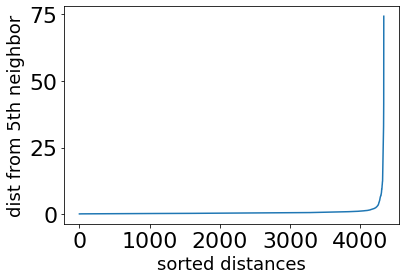

In [8]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()
